### 1. Tạo pertured data và lưu giống data cũ (cal_metric.py)
    1. Tạo ra câu pertured va convert json và ghép label (pertured_folder/masked_data_json)
### 2. Lấy ra vector logit 
    1. convert interim -> txt 
    2. transform, prepare -> json 
    3. đưa json (masked data 0.1) vào model lấy logit, prediction -> cần tạo class để lấy cho cả origin data và masked data
### 3. convert label gold theo từ thành label gold theo token
### 4. Tính inf 

## Step 2

In [ ]:
!python ../data_transformations.py --transform_file '/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/SRL/transform_file_conll.yml'
# nhớ chỉnh lại đường dẫn trong file transform_file_conll.yml

In [ ]:

!python ../data_preparation.py \
        --task_file "/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/SRL/tasks_file_SRL.yml" \
        --data_dir ../MLM/coNLL_tsv_json \
        --max_seq_len 85

## Calculate metrics for data perturbation


In [ ]:

!python metrics_calculation.py \
    --data_mask_dir './data_mlm/perturbed_data/sum_neg_cos/' \
    --data_origin_dir './data_mlm/process_folder/coNLL_tsv_json/ner_json/'  \
    --model_path '../output/multi_task_model_9_13050.pt' \
    --log_name "cal_corr_inf_lhs" \
    --wriDir './data_mlm/perturbed_data/importance_score/'

## Calculate metrics for masked data

In [ ]:
!python metrics_calculation.py \
    --data_mask_dir './data_mlm/process_folder/mlm_output/' \
    --data_origin_dir './data_mlm/process_folder/coNLL_tsv_json/ner_json/'  \
    --model_path '../output/multi_task_model_9_13050.pt' \
    --log_name "comp_mask_token" \
    --is_mask_token True

## Calculate metrics for delete token data

In [ ]:
!python metrics_calculation.py \
    --data_mask_dir './data_mlm/process_folder/mlm_output/' \
    --data_origin_dir './data_mlm/process_folder/coNLL_tsv_json/ner_json/'  \
    --model_path '../output/multi_task_model_9_13050.pt' \
    --log_name "comp_del_mask_token" \
    --del_mask_token True

## Task 1.1 :

In [3]:
import pandas as pd
import os
from mlm_utils.transform_func import get_files
from datetime import datetime
import os
from mlm_utils.transform_func import get_files
from metrics_calculation import get_importance_score, evaluateWord
from data_maker import DataMaker
from infer_pipeline import inferPipeline
from logger_ import make_logger

/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-07-22 16:46:51.728397: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 16:46:51.768596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 16:46:52.491106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-22 16:46:53.263124: E tensorflow/compiler/xla/stream_executor/cuda/cu

In [ ]:
dataMaskedDir = './data_mlm/perturbed_data/avg_pos_cos_module/'
dataOriginDir = './data_mlm/process_folder/coNLL_tsv_json/ner_json/'
model_path = '../model_path/multi_task_model_9_13050.pt'


# setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = 'test_corr_inf_lhs', debugMode=True,
                    logFile=os.path.join(logDir, '{}.log'.format('test_corr_inf_lhs')), silent=True)
logger.info("logger created.")

pipe = inferPipeline(logger, model_path)
labelMap = pipe.taskParams.labelMap['conllsrl']
labelRn = {v:k for k,v in labelMap.items()}
 
file_mask = sorted(get_files(dataMaskedDir))
file_origin = sorted(get_files(dataOriginDir))
all_pair_score = []

for mask, origin in zip(file_mask, file_origin):   
    resultwordMasked = evaluateWord(dataMaskedDir, mask, pipe.model, labelRn, hasTrueLabels=False, needMetrics=False, is_mask_token=False, del_mask_token=False)
    resultOrigin = evaluateWord(dataOriginDir, origin, pipe.model, labelRn, hasTrueLabels=True, needMetrics=False)

    # labelMap = {v: k for k, v in labelRn.items()}
    score_dict, list_pair_score = get_importance_score(resultOrigin, resultwordMasked, labelMap)
    all_pair_score.extend(list_pair_score)

In [ ]:
len(all_pair_score)

1022

In [3]:
# read csv 
score = '/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/perturbed_data/importance_score_avg_pos_cos_module/'
pas_inf = '/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/PAS_knowledge/' 
files = get_files(score)
pas_files = get_files(pas_inf)
all_cosine = pd.DataFrame()
all_pas = pd.DataFrame()
for file, pas_file in zip(files, pas_files):
    print(file, pas_file)
    cos = pd.read_csv(os.path.join(score, file), sep='\t')
    all_cosine = pd.concat([all_cosine, cos], axis=0, ignore_index = True)
    
    pas = pd.read_csv(os.path.join(pas_inf, pas_file))
    all_pas = pd.concat([all_pas, pas], axis=0, ignore_index = True)
    
    # drop nan
    all_cosine = all_cosine.dropna()
    all_pas = all_pas.dropna()
    

pair_score_abolish.csv mlm_abolish_full.csv
pair_score_alter.csv mlm_alter_full.csv
pair_score_begin_1.csv mlm_begin_1_full.csv
pair_score_begin_2.csv mlm_begin_2_full.csv
pair_score_block.csv mlm_block_full.csv
pair_score_catalyse.csv mlm_catalyse_full.csv
pair_score_confer.csv mlm_confer_full.csv
pair_score_decrease_1.csv mlm_decrease_1_full.csv
pair_score_decrease_2.csv mlm_decrease_2_full.csv
pair_score_delete.csv mlm_delete_full.csv
pair_score_develop.csv mlm_develop_full.csv
pair_score_disrupt.csv mlm_disrupt_full.csv
pair_score_eliminate.csv mlm_eliminate_full.csv
pair_score_encode.csv mlm_encode_full.csv
pair_score_express.csv mlm_express_full.csv
pair_score_generate.csv mlm_generate_full.csv
pair_score_inhibit.csv mlm_inhibit_full.csv
pair_score_initiate.csv mlm_initiate_full.csv
pair_score_lead.csv mlm_lead_full.csv
pair_score_lose.csv mlm_lose_full.csv
pair_score_modify.csv mlm_modify_full.csv
pair_score_mutate.csv mlm_mutate_full.csv
pair_score_proliferate.csv mlm_prolifera

In [4]:
all_cosine.shape

(83232, 4)

In [5]:
all_cosine.columns

Index(['uid', 'influence', 'relevance', 'brier_score'], dtype='object')

In [6]:
all_pas.shape

(83232, 7)

In [7]:
all_pas.columns

Index(['uid', 'cos_sim', 'cos_mo', 'ele_sub_neg', 'cos_dif', 'cos_mo_dif',
       'ele_sub'],
      dtype='object')

In [8]:
import numpy as np
from scipy.stats import spearmanr
for col in all_pas.columns[1:]:
    correlation_coefficient, p_value = spearmanr(all_cosine['relevance'], all_pas[col])
    print(col, correlation_coefficient, p_value)
    

cos_sim 0.0333776226794917 5.859596965062307e-22
cos_mo 0.02772554275937736 1.2419232070246777e-15
ele_sub_neg -0.25551198117750207 0.0
cos_dif -0.0033978376573552387 0.32695641269095943
cos_mo_dif -0.021068825025361382 1.2098693531844976e-09
ele_sub 0.25551198117750207 0.0


In [ ]:
pas_inf = '/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/PAS_knowledge/' 

pas_files = get_files(pas_inf)
all_pas = pd.DataFrame()
all_avg = pd.DataFrame()
for file in pas_files:
   
    pas = pd.read_csv(os.path.join(pas_inf, file))
    pas = pas.dropna()
    
    # get average of each columns
    avg = pas.mean(axis=0)
    avg = avg.to_frame().T
    avg['file'] = file.replace('mlm_', '').replace('_full.csv', '')
    all_avg = pd.concat([all_avg, avg], axis=0, ignore_index = True)
    # drop nan
   

In [10]:
all_avg.shape

(35, 7)

In [11]:
all_avg.head()

,cos_sim,cos_mo,ele_sub_neg,cos_dif,cos_mo_dif,ele_sub,file
0,-0.006991,-0.005728,-1.022529,0.975287,0.978200,1.022529,abolish
1,-0.012353,-0.010508,-0.942612,0.973449,0.976715,0.942612,alter
2,-0.027731,-0.023953,-0.850819,0.964781,0.969429,0.850819,begin_1
3,-0.009171,-0.007692,-0.878912,0.976034,0.979272,0.878912,begin_2
4,-0.016837,-0.014419,-1.191545,0.978128,0.981188,1.191545,block


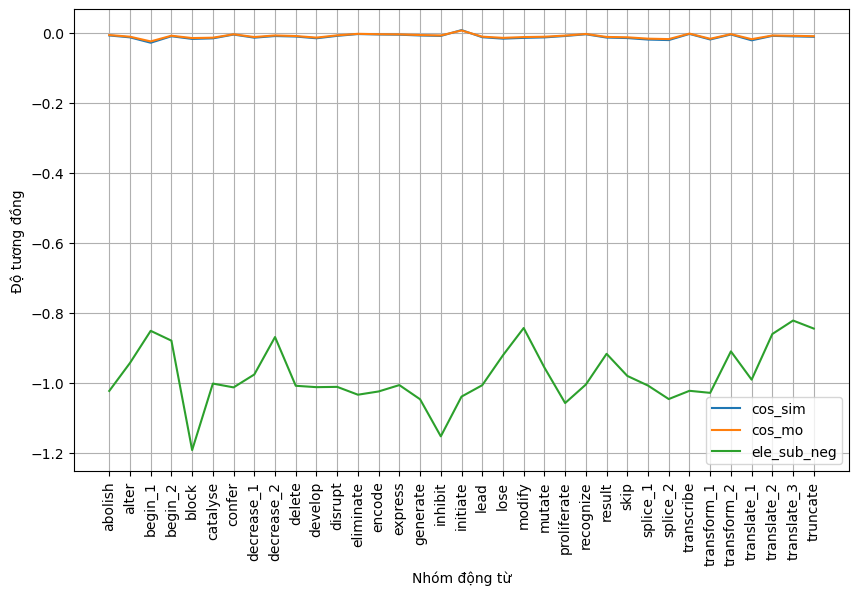

In [15]:
# visualize 3 first columns of all_avg using scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

# using multiline plot
plt.figure(figsize=(10, 6))
plt.xlabel('Nhóm động từ')
plt.ylabel('Độ tương đồng')
sns.lineplot(data=all_avg, x='file', y='cos_sim', label='cos_sim')
sns.lineplot(data=all_avg, x='file', y='cos_mo', label='cos_mo')
sns.lineplot(data=all_avg, x='file', y='ele_sub_neg', label='ele_sub_neg')
plt.xticks(rotation=90)
plt.grid()
plt.show()

    